<a href="https://colab.research.google.com/github/KelseyNager/GenAI/blob/main/Assignment_6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Music Generation with Transformers
##Kelsey Nager
##CSC 330

####THe purpose of this code

In [1]:
!apt-get install musescore
!apt-get install music21
!apt-get install fluidsynth

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  desktop-file-utils fonts-freefont-ttf libevdev2 libgudev-1.0-0 libinput-bin libinput10 libmd4c0
  libmtdev1 libportaudio2 libportmidi0 libqt5core5a libqt5dbus5 libqt5gui5 libqt5help5
  libqt5network5 libqt5printsupport5 libqt5qml5 libqt5qmlmodels5 libqt5qmlworkerscript5
  libqt5quick5 libqt5sql5 libqt5sql5-sqlite libqt5svg5 libqt5widgets5 libqt5xml5 libqt5xmlpatterns5
  libwacom-bin libwacom-common libwacom9 libxcb-icccm4 libxcb-image0 libxcb-keysyms1
  libxcb-render-util0 libxcb-util1 libxcb-xinerama0 libxcb-xinput0 libxcb-xkb1 libxkbcommon-x11-0
  musescore-common musescore-general-soundfont-small qml-module-qt-labs-folderlistmodel
  qml-module-qt-labs-settings qml-module-qtgraphicaleffects qml-module-qtqml
  qml-module-qtqml-models2 qml-module-qtquick-controls qml-module-qtquick-dialogs
  qml-module-qtquick-layouts qml-module-qtquick

In [2]:
%%writefile transformer_utils.py
import music21

Writing transformer_utils.py


In [3]:
!pip install music21

In [36]:
%load_ext autoreload
%autoreload 2

import os
import glob
import numpy as np
import time
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers, models, losses, callbacks

import pickle
import music21
import keras

from fractions import Fraction


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#Parameters

In [37]:
PARSE_MIDI_FILES = True
PARSED_DATA_PATH = "/content/data/"
DATASET_REPETITIONS = 1

SEQ_LEN = 64  # Sequence length
EMBEDDING_DIM = 256
KEY_DIM = 256
N_HEADS = 4
DROPOUT_RATE = 0.3
FEED_FORWARD_DIM = 256
LOAD_MODEL = False

# optimization
EPOCHS = 100
BATCH_SIZE = 64

GENERATE_LEN = 50

In [47]:
def parse_midi_files(file_list, parser, seq_len, parsed_data_path=None):
    os.makedirs(parsed_data_path, exist_ok=True)

    notes_list = []
    duration_list = []
    notes = []
    durations = []

    for i, file in enumerate(file_list):
        print(i + 1, "Parsing %s" % file)
        score = parser.parse(file).chordify()

        notes.append("START")
        durations.append("0.0")

        for element in score.flat:
            note_name = None
            duration_name = None

            if isinstance(element, music21.key.Key):
                note_name = str(element.tonic.name) + ":" + str(element.mode)
                duration_name = "0.0"

            elif isinstance(element, music21.meter.TimeSignature):
                note_name = str(element.ratioString) + "TS"
                duration_name = "0.0"

            elif isinstance(element, music21.chord.Chord):
                note_name = element.pitches[-1].nameWithOctave
                duration_name = str(element.duration.quarterLength)

            elif isinstance(element, music21.note.Rest):
                note_name = str(element.name)
                duration_name = str(element.duration.quarterLength)

            elif isinstance(element, music21.note.Note):
                note_name = str(element.nameWithOctave)
                duration_name = str(element.duration.quarterLength)

            if note_name and duration_name:
                notes.append(note_name)
                durations.append(duration_name)
        print(f"{len(notes)} notes parsed")

    notes_list = []
    duration_list = []
    print(f"Building sequences of length {seq_len}")
    for i in range(len(notes) - seq_len):
        notes_list.append(" ".join(notes[i : (i + seq_len)]))
        duration_list.append(" ".join(durations[i : (i + seq_len)]))

    if parsed_data_path:
        with open(os.path.join(parsed_data_path, "notes"), "wb") as f:
            pickle.dump(notes_list, f)
        with open(os.path.join(parsed_data_path, "durations"), "wb") as f:
            pickle.dump(duration_list, f)

    return notes_list, duration_list

In [48]:
def load_parsed_files(parsed_data_path):
    with open(os.path.join(parsed_data_path, "notes"), "rb") as f:
        notes = pickle.load(f)
    with open(os.path.join(parsed_data_path, "durations"), "rb") as f:
        durations = pickle.load(f)
    return notes, durations


In [49]:
def get_midi_note(sample_note, sample_duration):
    new_note = None

    if "TS" in sample_note:
        new_note = music21.meter.TimeSignature(sample_note.split("TS")[0])

    elif "major" in sample_note or "minor" in sample_note:
        tonic, mode = sample_note.split(":")
        new_note = music21.key.Key(tonic, mode)

    elif sample_note == "rest":
        new_note = music21.note.Rest()
        new_note.duration = music21.duration.Duration(
            float(Fraction(sample_duration))
        )
        new_note.storedInstrument = music21.instrument.Violoncello()

    elif "." in sample_note:
        notes_in_chord = sample_note.split(".")
        chord_notes = []
        for current_note in notes_in_chord:
            n = music21.note.Note(current_note)
            n.duration = music21.duration.Duration(
                float(Fraction(sample_duration))
            )
            n.storedInstrument = music21.instrument.Violoncello()
            chord_notes.append(n)
        new_note = music21.chord.Chord(chord_notes)

    elif sample_note == "rest":
        new_note = music21.note.Rest()
        new_note.duration = music21.duration.Duration(
            float(Fraction(sample_duration))
        )
        new_note.storedInstrument = music21.instrument.Violoncello()

    elif sample_note != "START":
        new_note = music21.note.Note(sample_note)
        new_note.duration = music21.duration.Duration(
            float(Fraction(sample_duration))
        )
        new_note.storedInstrument = music21.instrument.Violoncello()

    return new_note


In [50]:
class SinePositionEncoding(keras.layers.Layer):
    """Sinusoidal positional encoding layer.
    This layer calculates the position encoding as a mix of sine and cosine
    functions with geometrically increasing wavelengths. Defined and formulized
    in [Attention is All You Need](https://arxiv.org/abs/1706.03762).
    Takes as input an embedded token tensor. The input must have shape
    [batch_size, sequence_length, feature_size]. This layer will return a
    positional encoding the same size as the embedded token tensor, which
    can be added directly to the embedded token tensor.
    Args:
        max_wavelength: The maximum angular wavelength of the sine/cosine
            curves, as described in Attention is All You Need. Defaults to
            10000.
    Examples:
    ```python
    # create a simple embedding layer with sinusoidal positional encoding
    seq_len = 100
    vocab_size = 1000
    embedding_dim = 32
    inputs = keras.Input((seq_len,), dtype=tf.float32)
    embedding = keras.layers.Embedding(
        input_dim=vocab_size, output_dim=embedding_dim
    )(inputs)
    positional_encoding = keras_nlp.layers.SinePositionEncoding()(embedding)
    outputs = embedding + positional_encoding
    ```
    References:
     - [Vaswani et al., 2017](https://arxiv.org/abs/1706.03762)
    """

    def __init__(
        self,
        max_wavelength=10000,
        **kwargs,
    ):
        super().__init__(**kwargs)
        self.max_wavelength = max_wavelength

    def call(self, inputs):
        # TODO(jbischof): replace `hidden_size` with`hidden_dim` for consistency
        # with other layers.
        input_shape = tf.shape(inputs)
        # length of sequence is the second last dimension of the inputs
        seq_length = input_shape[-2]
        hidden_size = input_shape[-1]
        position = tf.cast(tf.range(seq_length), self.compute_dtype)
        min_freq = tf.cast(1 / self.max_wavelength, dtype=self.compute_dtype)
        timescales = tf.pow(
            min_freq,
            tf.cast(2 * (tf.range(hidden_size) // 2), self.compute_dtype)
            / tf.cast(hidden_size, self.compute_dtype),
        )
        angles = tf.expand_dims(position, 1) * tf.expand_dims(timescales, 0)
        # even indices are sine, odd are cosine
        cos_mask = tf.cast(tf.range(hidden_size) % 2, self.compute_dtype)
        sin_mask = 1 - cos_mask
        # embedding shape is [seq_length, hidden_size]
        positional_encodings = (
            tf.sin(angles) * sin_mask + tf.cos(angles) * cos_mask
        )

        return tf.broadcast_to(positional_encodings, input_shape)

    def get_config(self):
        config = super().get_config()
        config.update(
            {
                "max_wavelength": self.max_wavelength,
            }
        )
        return config

Prepare the Data

In [51]:
# Load the data
from google.colab import drive
drive.mount('/content/drive')


import glob
tchai_folder_path = '/content/drive/MyDrive/tchai/**/*.mid' # For files with .mid extension
tchai_folder_path2 = '/content/drive/MyDrive/tchai/**/*.midi' # For files with .midi extension

file_list_mid = glob.glob(tchai_folder_path, recursive=True)
file_list_midi = glob.glob(tchai_folder_path2, recursive=True)

file_list = file_list_mid + file_list_midi

print(f"Found {len(file_list)} midi files")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Found 23 midi files


In [52]:
parser = music21.converter

In [53]:
example_score = (
    music21.converter.parse(file_list[1]).splitAtQuarterLength(12)[0].chordify()
)

In [54]:
example_score.show("text")

{0.0} <music21.metadata.Metadata object at 0x7d618b72e440>
{0.0} <music21.stream.Measure 1 offset=0.0>
    {0.0} <music21.instrument.Flute 'Flute'>
    {0.0} <music21.instrument.Flute 'Flute'>
    {0.0} <music21.instrument.Flute 'Flute'>
    {0.0} <music21.instrument.Flute '3 Flutes: 3 Flutes'>
    {0.0} <music21.clef.TrebleClef>
    {0.0} <music21.tempo.MetronomeMark larghetto Quarter=62>
    {0.0} <music21.key.Key of G major>
    {0.0} <music21.meter.TimeSignature 2/4>
    {0.0} <music21.chord.Chord E2 E3>
    {0.5} <music21.chord.Chord G3 B3 E4>
    {1.0} <music21.chord.Chord E2 E3>
    {1.5} <music21.chord.Chord A3 C4 F#4>
{2.0} <music21.stream.Measure 2 offset=2.0>
    {0.0} <music21.chord.Chord E2 E3>
    {0.5} <music21.chord.Chord B-3 C#4 G4>
    {1.0} <music21.chord.Chord E2 E3>
    {1.5} <music21.chord.Chord A3 C4 E-4>
{4.0} <music21.stream.Measure 3 offset=4.0>
    {0.0} <music21.chord.Chord E2 E3>
    {0.5} <music21.chord.Chord G3 B3 E4>
    {1.0} <music21.chord.Chord E2 E3>

In [55]:
if PARSE_MIDI_FILES:
    notes, durations = parse_midi_files(
        file_list, parser, SEQ_LEN + 1, PARSED_DATA_PATH
    )
else:
    notes, durations = load_parsed_files()

1 Parsing /content/drive/MyDrive/tchai/tchaikovsky_nutcracker_suite_overture_71a_1_(c)kirschbaum.mid


<ipython-input-55-04172d0f16ff>:2: Music21DeprecationWarning: .flat is deprecated.  Call .flatten() instead
  notes, durations = parse_midi_files(


1310 notes parsed
2 Parsing /content/drive/MyDrive/tchai/sugar-plum-fairy.mid
1698 notes parsed
3 Parsing /content/drive/MyDrive/tchai/tchaikovsky_nutcracker_act-1_0_overture_(c)yogore.mid
3008 notes parsed
4 Parsing /content/drive/MyDrive/tchai/nutcrkr1.mid
4341 notes parsed
5 Parsing /content/drive/MyDrive/tchai/Tchaikovsky_-_Waltz_The_Sleeping_Beauty_Full_Piano_Solo_Medium.mid
6032 notes parsed
6 Parsing /content/drive/MyDrive/tchai/tchai1.mid
6485 notes parsed
7 Parsing /content/drive/MyDrive/tchai/tchai2.mid
11267 notes parsed
8 Parsing /content/drive/MyDrive/tchai/tchai3.mid
12774 notes parsed
9 Parsing /content/drive/MyDrive/tchai/tchai4.mid
13177 notes parsed
10 Parsing /content/drive/MyDrive/tchai/tchai5.mid
13796 notes parsed
11 Parsing /content/drive/MyDrive/tchai/tchai6.mid
17856 notes parsed
12 Parsing /content/drive/MyDrive/tchai/tchai7.mid
19997 notes parsed
13 Parsing /content/drive/MyDrive/tchai/tchai8.mid
21542 notes parsed
14 Parsing /content/drive/MyDrive/tchai/[Fre

In [56]:
example_notes = notes[600]
example_durations = durations[600]
print("\nNotes string\n", example_notes, "...")
print("\nDuration string\n", example_durations, "...")


Notes string
 G6 E6 G6 F6 F6 F6 G6 G6 G6 E6 G6 F6 F6 F6 G6 G6 G6 E6 G6 F6 F6 F6 D6 C6 B5 C6 B-5 A5 A5 A5 G5 F5 F5 F5 D5 C5 G5 F5 B-5 A5 D6 C6 F6 F6 E6 E6 F6 F6 rest B-5 rest E-6 rest D6 C6 C6 G6 rest F6 rest B-5 B-3 E-6 E-6 D6 ...

Duration string
 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.5 0.25 0.75 0.25 0.5 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 ...


#Tokenize the Data

In [57]:
def create_dataset(elements):
    ds = (
        tf.data.Dataset.from_tensor_slices(elements)
        .batch(BATCH_SIZE, drop_remainder=True)
        .shuffle(1000)
    )
    vectorize_layer = layers.TextVectorization(
        standardize=None, output_mode="int"
    )
    vectorize_layer.adapt(ds)
    vocab = vectorize_layer.get_vocabulary()
    return ds, vectorize_layer, vocab


notes_seq_ds, notes_vectorize_layer, notes_vocab = create_dataset(notes)
durations_seq_ds, durations_vectorize_layer, durations_vocab = create_dataset(
    durations
)
seq_ds = tf.data.Dataset.zip((notes_seq_ds, durations_seq_ds))

In [58]:
# Display the same example notes and durations converted to ints
example_tokenised_notes = notes_vectorize_layer(example_notes)
example_tokenised_durations = durations_vectorize_layer(example_durations)
print("{:10} {:10}".format("note token", "duration token"))
for i, (note_int, duration_int) in enumerate(
    zip(
        example_tokenised_notes.numpy()[:11],
        example_tokenised_durations.numpy()[:11],
    )
):
    print(f"{note_int:10}{duration_int:10}")

note token duration token
        26         2
        23         2
        26         2
        21         2
        21         2
        21         2
        26         2
        26         2
        26         2
        23         2
        26         2


In [59]:
notes_vocab_size = len(notes_vocab)
durations_vocab_size = len(durations_vocab)
vocab = notes_vocab + durations_vocab
vocab_size = len(vocab)

# Display some token:note mappings
print(f"\nNOTES_VOCAB: length = {len(notes_vocab)}")
for i, note in enumerate(notes_vocab[:10]):
    print(f"{i}: {note}")

print(f"\nDURATIONS_VOCAB: length = {len(durations_vocab)}")
# Display some token:duration mappings
for i, note in enumerate(durations_vocab[:10]):
    print(f"{i}: {note}")


NOTES_VOCAB: length = 98
0: 
1: [UNK]
2: rest
3: D5
4: E5
5: F5
6: A5
7: C5
8: G5
9: A4

DURATIONS_VOCAB: length = 38
0: 
1: [UNK]
2: 0.25
3: 0.5
4: 1/12
5: 1/3
6: 1.0
7: 1/6
8: 0.75
9: 2/3


#Training Set

In [60]:

# Create the training set of sequences and the same sequences shifted by one note
def prepare_inputs(notes, durations):
    notes = tf.expand_dims(notes, -1)
    durations = tf.expand_dims(durations, -1)
    tokenized_notes = notes_vectorize_layer(notes)
    tokenized_durations = durations_vectorize_layer(durations)
    x = (tokenized_notes[:, :-1], tokenized_durations[:, :-1])
    y = (tokenized_notes[:, 1:], tokenized_durations[:, 1:])
    return x, y


ds = seq_ds.map(prepare_inputs).repeat(DATASET_REPETITIONS)

In [61]:
example_input_output = ds.take(1).get_single_element()
print(example_input_output)

((<tf.Tensor: shape=(64, 64), dtype=int64, numpy=
array([[28,  2, 19, ..., 10, 28, 28],
       [ 2, 19,  2, ..., 28, 28,  4],
       [19,  2, 15, ..., 28,  4,  2],
       ...,
       [10, 28, 28, ..., 17, 33,  9],
       [28, 28,  4, ..., 33,  9, 33],
       [28,  4,  2, ...,  9, 33,  6]])>, <tf.Tensor: shape=(64, 64), dtype=int64, numpy=
array([[3, 2, 2, ..., 5, 5, 2],
       [2, 2, 5, ..., 5, 2, 4],
       [2, 5, 4, ..., 2, 4, 5],
       ...,
       [5, 5, 2, ..., 2, 9, 5],
       [5, 2, 4, ..., 9, 5, 2],
       [2, 4, 5, ..., 5, 2, 8]])>), (<tf.Tensor: shape=(64, 64), dtype=int64, numpy=
array([[ 2, 19,  2, ..., 28, 28,  4],
       [19,  2, 15, ..., 28,  4,  2],
       [ 2, 15,  2, ...,  4,  2, 22],
       ...,
       [28, 28,  4, ..., 33,  9, 33],
       [28,  4,  2, ...,  9, 33,  6],
       [ 4,  2, 22, ..., 33,  6,  6]])>, <tf.Tensor: shape=(64, 64), dtype=int64, numpy=
array([[2, 2, 5, ..., 5, 2, 4],
       [2, 5, 4, ..., 2, 4, 5],
       [5, 4, 2, ..., 4, 5, 5],
       ...,
   

#Create the causal attention mask function

In [62]:
def causal_attention_mask(batch_size, n_dest, n_src, dtype):
    i = tf.range(n_dest)[:, None]
    j = tf.range(n_src)
    m = i >= j - n_src + n_dest
    mask = tf.cast(m, dtype)
    mask = tf.reshape(mask, [1, n_dest, n_src])
    mult = tf.concat(
        [tf.expand_dims(batch_size, -1), tf.constant([1, 1], dtype=tf.int32)], 0
    )
    return tf.tile(mask, mult)


np.transpose(causal_attention_mask(1, 10, 10, dtype=tf.int32)[0])

array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 1, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1]], dtype=int32)

#Create a Transformer Block Layer

In [63]:
class TransformerBlock(layers.Layer):
    def __init__(
        self,
        num_heads,
        key_dim,
        embed_dim,
        ff_dim,
        name,
        dropout_rate=DROPOUT_RATE,
    ):
        super(TransformerBlock, self).__init__(name=name)
        self.num_heads = num_heads
        self.key_dim = key_dim
        self.embed_dim = embed_dim
        self.ff_dim = ff_dim
        self.dropout_rate = dropout_rate
        self.attn = layers.MultiHeadAttention(
            num_heads, key_dim, output_shape=embed_dim
        )
        self.dropout_1 = layers.Dropout(self.dropout_rate)
        self.ln_1 = layers.LayerNormalization(epsilon=1e-6)
        self.ffn_1 = layers.Dense(self.ff_dim, activation="relu")
        self.ffn_2 = layers.Dense(self.embed_dim)
        self.dropout_2 = layers.Dropout(self.dropout_rate)
        self.ln_2 = layers.LayerNormalization(epsilon=1e-6)

    def call(self, inputs):
        input_shape = tf.shape(inputs)
        batch_size = input_shape[0]
        seq_len = input_shape[1]
        causal_mask = causal_attention_mask(
            batch_size, seq_len, seq_len, tf.bool
        )
        attention_output, attention_scores = self.attn(
            inputs,
            inputs,
            attention_mask=causal_mask,
            return_attention_scores=True,
        )
        attention_output = self.dropout_1(attention_output)
        out1 = self.ln_1(inputs + attention_output)
        ffn_1 = self.ffn_1(out1)
        ffn_2 = self.ffn_2(ffn_1)
        ffn_output = self.dropout_2(ffn_2)
        return (self.ln_2(out1 + ffn_output), attention_scores)

    def get_config(self):
        config = super().get_config()
        config.update(
            {
                "key_dim": self.key_dim,
                "embed_dim": self.embed_dim,
                "num_heads": self.num_heads,
                "ff_dim": self.ff_dim,
                "dropout_rate": self.dropout_rate,
            }
        )
        return config

#Create the Token and Position Embedding

In [64]:
class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim
        self.token_emb = layers.Embedding(
            input_dim=vocab_size,
            output_dim=embed_dim,
            embeddings_initializer="he_uniform",
        )
        self.pos_emb = SinePositionEncoding()

    def call(self, x):
        embedding = self.token_emb(x)
        positions = self.pos_emb(embedding)
        return embedding + positions

    def get_config(self):
        config = super().get_config()
        config.update(
            {
                "vocab_size": self.vocab_size,
                "embed_dim": self.embed_dim,
            }
        )
        return config

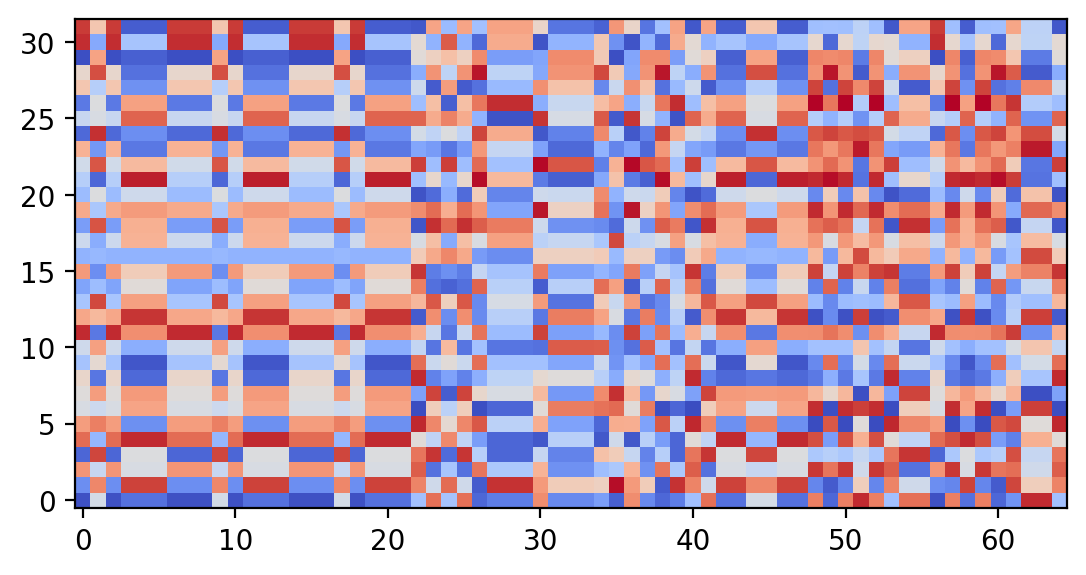

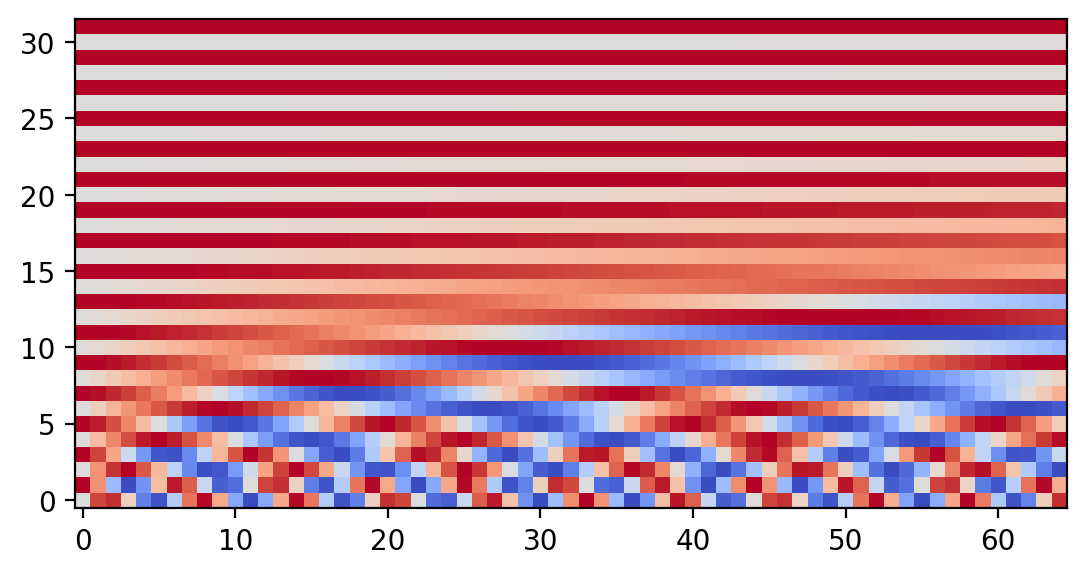

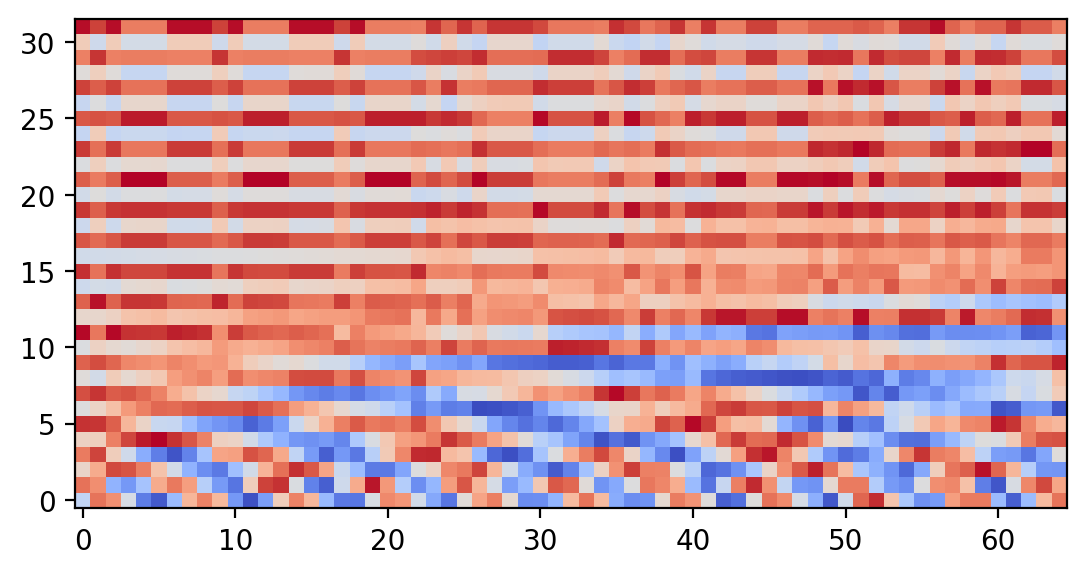

In [65]:
tpe = TokenAndPositionEmbedding(notes_vocab_size, 32)
token_embedding = tpe.token_emb(example_tokenised_notes)
position_embedding = tpe.pos_emb(token_embedding)
embedding = tpe(example_tokenised_notes)
plt.imshow(
    np.transpose(token_embedding),
    cmap="coolwarm",
    interpolation="nearest",
    origin="lower",
)
plt.show()
plt.imshow(
    np.transpose(position_embedding),
    cmap="coolwarm",
    interpolation="nearest",
    origin="lower",
)
plt.show()
plt.imshow(
    np.transpose(embedding),
    cmap="coolwarm",
    interpolation="nearest",
    origin="lower",
)
plt.show()

#Build the Transformer Model

In [66]:
note_inputs = layers.Input(shape=(None,), dtype=tf.int32)
durations_inputs = layers.Input(shape=(None,), dtype=tf.int32)
note_embeddings = TokenAndPositionEmbedding(
    notes_vocab_size, EMBEDDING_DIM // 2
)(note_inputs)
duration_embeddings = TokenAndPositionEmbedding(
    durations_vocab_size, EMBEDDING_DIM // 2
)(durations_inputs)
embeddings = layers.Concatenate()([note_embeddings, duration_embeddings])
x, attention_scores = TransformerBlock(
    N_HEADS, KEY_DIM, EMBEDDING_DIM, FEED_FORWARD_DIM, name="attention"
)(embeddings)
note_outputs = layers.Dense(
    notes_vocab_size, activation="softmax", name="note_outputs"
)(x)
duration_outputs = layers.Dense(
    durations_vocab_size, activation="softmax", name="duration_outputs"
)(x)
model = models.Model(
    inputs=[note_inputs, durations_inputs],
    outputs=[note_outputs, duration_outputs],  # attention_scores
)
model.compile(
    "adam",
    loss=[
        losses.SparseCategoricalCrossentropy(),
        losses.SparseCategoricalCrossentropy(),
    ],
)
att_model = models.Model(
    inputs=[note_inputs, durations_inputs], outputs=attention_scores
)


In [67]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, None)           │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_1             │ (None, None)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ token_and_position_embed… │ (None, None, 128)      │         12,544 │ input_layer[0][0]      │
│ (TokenAndPositionEmbeddi… │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ token_and_position_embed… │ (None, None, 128)      │          4,864 │ input_layer_1[0][0]    │
│ (TokenAndPositionEmbeddi… │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, None, 256)      │              0 │ token_and_position_em… │
│                           │                        │                │ token_and_position_em… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ attention                 │ [(None, None, 256),    │      1,184,512 │ concatenate[0][0]      │
│ (TransformerBlock)        │ (None, 4, None, None)] │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ note_outputs (Dense)      │ (None, None, 98)       │         25,186 │ attention[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ duration_outputs (Dense)  │ (None, None, 38)       │          9,766 │ attention[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 1,236,872 (4.72 MB)

 Trainable params: 1,236,872 (4.72 MB)

 Non-trainable params: 0 (0.00 B)

#Train the Transformer

In [68]:
# Create a MusicGenerator checkpoint
class MusicGenerator(callbacks.Callback):
    def __init__(self, index_to_note, index_to_duration, top_k=10):
        self.index_to_note = index_to_note
        self.note_to_index = {
            note: index for index, note in enumerate(index_to_note)
        }
        self.index_to_duration = index_to_duration
        self.duration_to_index = {
            duration: index for index, duration in enumerate(index_to_duration)
        }

    def sample_from(self, probs, temperature):
        probs = probs ** (1 / temperature)
        probs = probs / np.sum(probs)
        return np.random.choice(len(probs), p=probs), probs

    def get_note(self, notes, durations, temperature):
        sample_note_idx = 1
        while sample_note_idx == 1:
            sample_note_idx, note_probs = self.sample_from(
                notes[0][-1], temperature
            )
            sample_note = self.index_to_note[sample_note_idx]

        sample_duration_idx = 1
        while sample_duration_idx == 1:
            sample_duration_idx, duration_probs = self.sample_from(
                durations[0][-1], temperature
            )
            sample_duration = self.index_to_duration[sample_duration_idx]

        new_note = get_midi_note(sample_note, sample_duration)

        return (
            new_note,
            sample_note_idx,
            sample_note,
            note_probs,
            sample_duration_idx,
            sample_duration,
            duration_probs,
        )

    def generate(self, start_notes, start_durations, max_tokens, temperature):
        attention_model = models.Model(
            inputs=self.model.input,
            outputs=self.model.get_layer("attention").output,
        )

        start_note_tokens = [self.note_to_index.get(x, 1) for x in start_notes]
        start_duration_tokens = [
            self.duration_to_index.get(x, 1) for x in start_durations
        ]
        sample_note = None
        sample_duration = None
        info = []
        midi_stream = music21.stream.Stream()

        midi_stream.append(music21.clef.BassClef())

        for sample_note, sample_duration in zip(start_notes, start_durations):
            new_note = get_midi_note(sample_note, sample_duration)
            if new_note is not None:
                midi_stream.append(new_note)

        while len(start_note_tokens) < max_tokens:
            x1 = np.array([start_note_tokens])
            x2 = np.array([start_duration_tokens])
            notes, durations = self.model.predict([x1, x2], verbose=0)

            repeat = True

            while repeat:
                (
                    new_note,
                    sample_note_idx,
                    sample_note,
                    note_probs,
                    sample_duration_idx,
                    sample_duration,
                    duration_probs,
                ) = self.get_note(notes, durations, temperature)

                if (
                    isinstance(new_note, music21.chord.Chord)
                    or isinstance(new_note, music21.note.Note)
                    or isinstance(new_note, music21.note.Rest)
                ) and sample_duration == "0.0":
                    repeat = True
                else:
                    repeat = False

            if new_note is not None:
                midi_stream.append(new_note)

            _, att = attention_model.predict([x1, x2], verbose=0)

            info.append(
                {
                    "prompt": [start_notes.copy(), start_durations.copy()],
                    "midi": midi_stream,
                    "chosen_note": (sample_note, sample_duration),
                    "note_probs": note_probs,
                    "duration_probs": duration_probs,
                    "atts": att[0, :, -1, :],
                }
            )
            start_note_tokens.append(sample_note_idx)
            start_duration_tokens.append(sample_duration_idx)
            start_notes.append(sample_note)
            start_durations.append(sample_duration)

            if sample_note == "START":
                break

        return info

    def on_epoch_end(self, epoch, logs=None):
        info = self.generate(
            ["START"], ["0.0"], max_tokens=GENERATE_LEN, temperature=0.5
        )
        midi_stream = info[-1]["midi"].chordify()
        print(info[-1]["prompt"])
        #midi_stream.show()
        midi_stream.write(
            "midi",
            fp=os.path.join(
                "/content/output",
                "output-" + str(epoch).zfill(4) + ".mid",
            ),
        )

In [69]:
# Tokenize starting prompt
music_generator = MusicGenerator(notes_vocab, durations_vocab)

In [70]:
model.fit(
    ds,
    epochs=100,
    callbacks=[
        music_generator,
    ],
)

Epoch 1/100
457/459 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - duration_outputs_loss: 1.7331 - loss: 5.5860 - note_outputs_loss: 3.8529

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis 3 of a tensor of shape (1, 4, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


[['START', 'B2', 'B2', 'F#2', 'F#2', 'F#2', 'F#2', 'F#2', 'F#2', 'F#2', 'F#2', 'F#2', 'F#2', 'F#2', 'F#2', 'F#2', 'F#2', 'F#2', 'F#2', 'F#2', 'F#2', 'F#2', 'F#2', 'F#2', 'F#2', 'F#2', 'F#2', 'F#2', 'F#2', 'F#2', 'F#2', 'F#2', 'F#2', 'F#2', 'F#2', 'F#2', 'F#2', 'F#2', 'F#2', 'F#2', 'F#2', 'F#2', 'F#2', 'F#2', 'F#2', 'F#2', 'F#2', 'F#2', 'F#2'], ['0.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '0.5', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '1.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]


FileNotFoundError: [Errno 2] No such file or directory: '/content/output/output-0000.mid'

In [ ]:
# Save the final model
model.save("/content/model")

#Generate Music Using the Transformer

In [ ]:
info = music_generator.generate(
    ["START"], ["0.0"], max_tokens=50, temperature=0.5
)
midi_stream = info[-1]["midi"].chordify()
#midi_stream.show()

Write Music to Midi File

In [ ]:
timestr = time.strftime("%Y%m%d-%H%M%S")
midi_stream.write(
    "midi",
    fp=os.path.join(
        "/content/transformer_output",
        "output-" + timestr + ".mid",
    ),
)

#Note Probabiltiies

In [ ]:
max_pitch = 70
seq_len = len(info)
grid = np.zeros((max_pitch, seq_len), dtype=np.float32)

for j in range(seq_len):
    for i, prob in enumerate(info[j]["note_probs"]):
        try:
            pitch = music21.note.Note(notes_vocab[i]).pitch.midi
            grid[pitch, j] = prob
        except:
            pass  # Don't show key / time signatures

In [ ]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.set_yticks([int(j) for j in range(35, 70)])
plt.imshow(
    grid[35:70, :],
    origin="lower",
    cmap="coolwarm",
    vmin=-0.5,
    vmax=0.5,
    extent=[0, seq_len, 35, 70],
)
plt.show()

#Attention Plot

In [ ]:
plot_size = 20

att_matrix = np.zeros((plot_size, plot_size))
prediction_output = []
last_prompt = []

In [ ]:
for j in range(plot_size):
    atts = info[j]["atts"].max(axis=0)
    att_matrix[: (j + 1), j] = atts
    prediction_output.append(info[j]["chosen_note"][0])
    last_prompt.append(info[j]["prompt"][0][-1])

In [ ]:
fig, ax = plt.subplots(figsize=(8, 8))
im = ax.imshow(att_matrix, cmap="Greens", interpolation="nearest")

ax.set_xticks(np.arange(-0.5, plot_size, 1), minor=True)
ax.set_yticks(np.arange(-0.5, plot_size, 1), minor=True)
ax.grid(which="minor", color="black", linestyle="-", linewidth=1)
ax.set_xticks(np.arange(plot_size))
ax.set_yticks(np.arange(plot_size))
ax.set_xticklabels(prediction_output[:plot_size])
ax.set_yticklabels(last_prompt[:plot_size])
ax.xaxis.tick_top()

plt.setp(
    ax.get_xticklabels(),
    rotation=90,
    ha="left",
    va="center",
    rotation_mode="anchor",
)
plt.show()


In [ ]:
from google.colab import files
import shutil

shutil.make_archive("/content/model", 'zip', "my_folder")
shutil.make_archive("/content/output", 'zip', "my_folder")
shutil.make_archive("/content/transformer_output", 'zip', "my_folder")
shutil.make_archive("/content/data", 'zip', "my_folder")


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# Saving the model and its data on the Google drive

!cp -r /content/data /content/drive/MyDrive/GenAI
!cp -r /content/model /content/drive/MyDrive/GenAI
!cp -r /content/output /content/drive/MyDrive/GenAI
!cp -r /content/transformer_output /content/drive/MyDrive/GenAI